# Data Preparation



In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pandas import Series, DataFrame
import time
import turicreate as tc
from sklearn.model_selection import train_test_split
from functools import reduce
import random

In [2]:
file1 = "Data1.csv"
file2 = "Data2.csv"


In [3]:
def pre_process_df(filename):
 
    if filename:
        df = pd.read_csv(filename)
        df = df.drop_duplicates()
        df = df[df.brand.notnull()]
        return df[df.price > 0]
    return None
  
def cal_purchase_count(files):
    df = pd.concat([pre_process_df(f) for f in files])
    df = df.loc[:, ['event_type', 'product_id', 'user_id']]
    df['purchase_count'] = [1 if e == 'purchase' else 0 for e in df['event_type']]
    df = df.drop(['event_type'], axis = 1)
    df = df.groupby(['product_id', 'user_id']).sum()
    df = df[df.purchase_count != 0]
    return df.reset_index()

In [4]:
purchase_count = cal_purchase_count([file1, file2])

In [5]:
user_id  = np.unique(purchase_count['user_id'])
num_product_purchased = np.zeros(len(user_id))
for loc, user in enumerate(user_id):
    num_product_purchased[loc] = np.sum(purchase_count['user_id'] == user)

In [6]:
idx = np.where(num_product_purchased>=10)

In [7]:
filitered_user_id = user_id[idx]

In [8]:
len(filitered_user_id)

9672

In [9]:
filtered_data = purchase_count.loc[purchase_count['user_id'].isin(filitered_user_id)]

In [10]:
len(np.unique(filtered_data['product_id']))

15813

In [11]:
len(filtered_data)

181048

In [12]:
#filtered_data.to_csv('product_user.csv')

In [13]:

sf = tc.SFrame(filtered_data)
train_data, test = tc.recommender.util.random_split_by_user(sf, user_id = 'user_id', item_id = 'product_id',max_num_users=18366,item_test_proportion= 0.2)
train_val, validation = tc.recommender.util.random_split_by_user(train_data, user_id = 'user_id', item_id = 'product_id',max_num_users=18366,item_test_proportion=0.25)

# Popularity Model

In [14]:
# constant variables to define field names include:
user_id = 'user_id'
item_id = 'product_id'
target = 'purchase_count'
# train model with train_data
pop_model = tc.popularity_recommender.create(train_data, user_id=user_id, item_id=item_id, target=target)

Preparing data set.

Data has 144830 observations with 9672 users and 15079 items.

Data prepared in: 0.352229s

144830 observations to process; with 15079 unique items.

In [15]:
results = pop_model.evaluate_precision_recall(test,cutoffs = list(range(1, 11)))

recommendations finished on 1000/9255 queries. users per second: 14610.1

recommendations finished on 2000/9255 queries. users per second: 18510.1

recommendations finished on 3000/9255 queries. users per second: 20125.3

recommendations finished on 4000/9255 queries. users per second: 20940.8

recommendations finished on 5000/9255 queries. users per second: 21569.9

recommendations finished on 6000/9255 queries. users per second: 22017.9

recommendations finished on 7000/9255 queries. users per second: 22247.8

recommendations finished on 8000/9255 queries. users per second: 22529.3

recommendations finished on 9000/9255 queries. users per second: 22713.2

In [16]:
col_names =  ['cutoff', 'precision', 'recall'] 
popularity_results  = pd.DataFrame(columns = col_names)
popularity_results['cutoff'] = np.array(results['precision_recall_overall']['cutoff'])
popularity_results['precision'] = np.array(results['precision_recall_overall']['precision'])
popularity_results['recall'] = np.array(results['precision_recall_overall']['recall'])

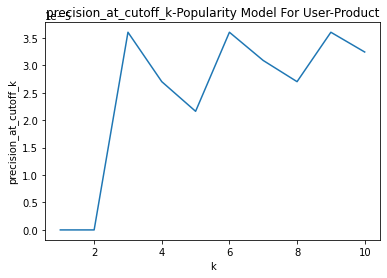

In [17]:
plt.plot(popularity_results['cutoff'],popularity_results['precision'] )
plt.title('precision_at_cutoff_k-Popularity Model For User-Product')
plt.xlabel('k')
plt.ylabel('precision_at_cutoff_k')
plt.show()

# Item Based CF - Cosine

In [18]:
# constant variables to define field names include:
user_id = 'user_id'
item_id = 'product_id'
target = 'purchase_count'

In [39]:
# hyperparameter tuning for S
test_s_values = np.arange(1,15,3)
def test_s_vals(name):
    s_list = []
    train = []
    val = []
    for loc, s in enumerate(test_s_values):
        model = tc.item_similarity_recommender.create(train_val,similarity_type=name,user_id=user_id, item_id=item_id,target = target,only_top_k=s)
        rmse_train = tc.recommender.util.compare_models(train_val, [model],exclude_known_for_precision_recall=False)
        rmse_train = rmse_train[0]['rmse_overall']
        s_list.append(s)
        train.append(rmse_train)
        rmse_val = tc.recommender.util.compare_models(validation, [model], model_names=["m1"], metric='rmse')
        rmse_val = rmse_val[0]['rmse_overall']
        rec = model.recommend(exclude_known = False)
        val.append(rmse_val)
    return s_list,train,val

In [40]:
# hyperparameter tuning for cosine similarity 
cosCF_s, cosCF_train, cosCF_val = test_s_vals('cosine')

Preparing data set.

Data has 108626 observations with 9672 users and 14105 items.

Data prepared in: 0.112028s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 835us                          | 10.25      |

| 4.662ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 953.608ms                           | 0                | 3               |

| 1.67s                               | 100              | 14105           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

PROGRESS: Evaluate model M0


Generating candidate set for working with new users.

Finished training in 1.69166s

recommendations finished on 1000/9672 queries. users per second: 20088

recommendations finished on 2000/9672 queries. users per second: 19663.7

recommendations finished on 3000/9672 queries. users per second: 18741.3

recommendations finished on 4000/9672 queries. users per second: 17739.7

recommendations finished on 5000/9672 queries. users per second: 16631.6

recommendations finished on 6000/9672 queries. users per second: 15971.8

recommendations finished on 7000/9672 queries. users per second: 16008

recommendations finished on 8000/9672 queries. users per second: 15987.8

recommendations finished on 9000/9672 queries. users per second: 16029.4


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.2815343258891648 | 0.02590371211498507 |
|   2    |  0.2743486352357316 | 0.05218372354603604 |
|   3    | 0.22966639095671354 | 0.06566654738786432 |
|   4    | 0.20034636062861866 | 0.07652834824972976 |
|   5    | 0.17890818858560784 | 0.08516729736562344 |
|   6    | 0.16199682933553897 | 0.09203399419992014 |
|   7    | 0.14854366064043506 | 0.09766070176824966 |
|   8    | 0.13629549214226633 | 0.10136819026108675 |
|   9    | 0.12573522654167799 | 0.10411751863772947 |
|   10   | 0.11709057071960315 | 0.10654090781273651 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0559162252439989

Per User RMSE (best)
+-----------+------+-------+
|  user_id  | rmse | count |
+-----------+------+-------+
| 554542746 |

recommendations finished on 1000/9672 queries. users per second: 22708.7

recommendations finished on 2000/9672 queries. users per second: 23523.6

recommendations finished on 3000/9672 queries. users per second: 22794.6

recommendations finished on 4000/9672 queries. users per second: 22547.9

recommendations finished on 5000/9672 queries. users per second: 22243.5

recommendations finished on 6000/9672 queries. users per second: 22185.9

recommendations finished on 7000/9672 queries. users per second: 22271.2

recommendations finished on 8000/9672 queries. users per second: 22191.4

recommendations finished on 9000/9672 queries. users per second: 22072.6

Preparing data set.

Data has 108626 observations with 9672 users and 14105 items.

Data prepared in: 0.067511s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 808us                          | 10.25      |

| 3.319ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 932.499ms                           | 0                | 0               |

| 1.59s                               | 100              | 14105           |

+-------------------------------------+------------------+-----------------+

PROGRESS: Evaluate model M0


Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.60755s

recommendations finished on 1000/9672 queries. users per second: 19943

recommendations finished on 2000/9672 queries. users per second: 19700.7

recommendations finished on 3000/9672 queries. users per second: 19212

recommendations finished on 4000/9672 queries. users per second: 18878.7

recommendations finished on 5000/9672 queries. users per second: 17631

recommendations finished on 6000/9672 queries. users per second: 17383

recommendations finished on 7000/9672 queries. users per second: 17074.6

recommendations finished on 8000/9672 queries. users per second: 17212.6

recommendations finished on 9000/9672 queries. users per second: 17345.5


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3471877584780808 | 0.03195403147605707 |
|   2    |  0.3224772539288669 | 0.05952258047598894 |
|   3    | 0.30193686242073403 | 0.08333963071991396 |
|   4    |  0.2830334987593044 | 0.10355315854180502 |
|   5    |  0.2635235732009926 |  0.1200731825286086 |
|   6    | 0.23736903777226318 | 0.13019342601977826 |
|   7    | 0.21682618456812003 |  0.1391175858424722 |
|   8    | 0.20024296939619535 | 0.14726794467751833 |
|   9    |  0.1866326624391142 |  0.1546439351364178 |
|   10   | 0.17500000000000013 | 0.16165773529797312 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0397490166928416

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

recommendations finished on 1000/9672 queries. users per second: 20589.3

recommendations finished on 2000/9672 queries. users per second: 21199

recommendations finished on 3000/9672 queries. users per second: 21197.8

recommendations finished on 4000/9672 queries. users per second: 21626.9

recommendations finished on 5000/9672 queries. users per second: 21028.5

recommendations finished on 6000/9672 queries. users per second: 20864.3

recommendations finished on 7000/9672 queries. users per second: 20544

recommendations finished on 8000/9672 queries. users per second: 18447.1

recommendations finished on 9000/9672 queries. users per second: 18602.6

Preparing data set.

Data has 108626 observations with 9672 users and 14105 items.

Data prepared in: 0.077805s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 881us                          | 10.25      |

| 4.034ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.04s                               | 0                | 0               |

| 1.83s                               | 100              | 14105           |

+-------------------------------------+------------------+-----------------+

PROGRESS: Evaluate model M0

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.84336s

recommendations finished on 1000/9672 queries. users per second: 18119.6

recommendations finished on 2000/9672 queries. users per second: 18511.3

recommendations finished on 3000/9672 queries. users per second: 18737.7

recommendations finished on 4000/9672 queries. users per second: 19019.8

recommendations finished on 5000/9672 queries. users per second: 18946.9

recommendations finished on 6000/9672 queries. users per second: 18824.8

recommendations finished on 7000/9672 queries. users per second: 18709.2

recommendations finished on 8000/9672 queries. users per second: 18675.4

recommendations finished on 9000/9672 queries. users per second: 18699.9


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.38554590570719655 | 0.03605073525173537 |
|   2    |  0.3588192721257238 | 0.06657668312578574 |
|   3    | 0.33933002481389607 | 0.09397905028156028 |
|   4    |  0.3188844086021501 | 0.11706772389101087 |
|   5    |  0.2996898263027294 | 0.13620797831870454 |
|   6    | 0.28106906534325915 |  0.1521666035505484 |
|   7    |  0.2650064988774658 | 0.16627475884352494 |
|   8    | 0.24952181555004135 | 0.17808882061126702 |
|   9    |  0.2324120025732931 | 0.18673336225843315 |
|   10   |  0.2172973531844498 |  0.1941319390472121 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 1.029539512674501

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+--

recommendations finished on 1000/9672 queries. users per second: 23516.1

recommendations finished on 2000/9672 queries. users per second: 22922.1

recommendations finished on 3000/9672 queries. users per second: 22978.6

recommendations finished on 4000/9672 queries. users per second: 21935.5

recommendations finished on 5000/9672 queries. users per second: 22140.1

recommendations finished on 6000/9672 queries. users per second: 21763.3

recommendations finished on 7000/9672 queries. users per second: 21810.9

recommendations finished on 8000/9672 queries. users per second: 21760.9

recommendations finished on 9000/9672 queries. users per second: 21907.6

Preparing data set.

Data has 108626 observations with 9672 users and 14105 items.

Data prepared in: 0.068694s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 652us                          | 10.25      |

| 2.82ms                         | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 908.571ms                           | 0                | 0               |

| 1.58s                               | 100              | 14105           |

+-------------------------------------+------------------+-----------------+

PROGRESS: Evaluate model M0


Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.59825s

recommendations finished on 1000/9672 queries. users per second: 16848.3

recommendations finished on 2000/9672 queries. users per second: 18071.1

recommendations finished on 3000/9672 queries. users per second: 18022

recommendations finished on 4000/9672 queries. users per second: 18426

recommendations finished on 5000/9672 queries. users per second: 18483.9

recommendations finished on 6000/9672 queries. users per second: 18445

recommendations finished on 7000/9672 queries. users per second: 18623.2

recommendations finished on 8000/9672 queries. users per second: 18636.3

recommendations finished on 9000/9672 queries. users per second: 18646


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.41552936311000843 | 0.039045934413712236 |
|   2    | 0.38704507857733655 | 0.07224811803987465  |
|   3    | 0.36707333884753324 | 0.10232176626660021  |
|   4    |  0.345972911497105  | 0.12754106204379934  |
|   5    |  0.3265508684863522 | 0.14907375562757433  |
|   6    |  0.3079507857733665 | 0.16701574043235443  |
|   7    |  0.2904998227578873 | 0.18247888906121673  |
|   8    | 0.27418062448304353 |  0.1953640646003364  |
|   9    | 0.25990258248322806 |  0.2068673811131047  |
|   10   | 0.24583333333333318 | 0.21615157373340296  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0224047824712827

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |


recommendations finished on 1000/9672 queries. users per second: 21528.1

recommendations finished on 2000/9672 queries. users per second: 21962.1

recommendations finished on 3000/9672 queries. users per second: 22264.4

recommendations finished on 4000/9672 queries. users per second: 21997.1

recommendations finished on 5000/9672 queries. users per second: 22066

recommendations finished on 6000/9672 queries. users per second: 21694.6

recommendations finished on 7000/9672 queries. users per second: 21895.9

recommendations finished on 8000/9672 queries. users per second: 21711.3

recommendations finished on 9000/9672 queries. users per second: 21779.4

Preparing data set.

Data has 108626 observations with 9672 users and 14105 items.

Data prepared in: 0.064418s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 790us                          | 10.25      |

| 2.602ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 921.057ms                           | 0                | 0               |

| 1.63s                               | 100              | 14105           |

+-------------------------------------+------------------+-----------------+

PROGRESS: Evaluate model M0


Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.64043s

recommendations finished on 1000/9672 queries. users per second: 18061.6

recommendations finished on 2000/9672 queries. users per second: 18282.9

recommendations finished on 3000/9672 queries. users per second: 18425.3

recommendations finished on 4000/9672 queries. users per second: 18594.9

recommendations finished on 5000/9672 queries. users per second: 18575.3

recommendations finished on 6000/9672 queries. users per second: 18460.3

recommendations finished on 7000/9672 queries. users per second: 18626.6

recommendations finished on 8000/9672 queries. users per second: 18712.1

recommendations finished on 9000/9672 queries. users per second: 18733.1


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.43589743589743574 | 0.04105122456974005 |
|   2    |  0.4082919768403641 | 0.07654842190023421 |
|   3    |  0.3879928315412185 | 0.10836579730241949 |
|   4    |  0.3673748966087678 | 0.13558484008148794 |
|   5    |  0.3476220016542588 |  0.1589020050445082 |
|   6    |  0.3293872346291702 | 0.17893418405089723 |
|   7    | 0.31137008153137097 |  0.1957081323343549 |
|   8    |  0.2947813275434245 |  0.2099689346561492 |
|   9    | 0.27948947707012195 |  0.2223179368906402 |
|   10   | 0.26516749379652627 |  0.2329128128136686 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0169035067739718

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

recommendations finished on 1000/9672 queries. users per second: 22601.9

recommendations finished on 2000/9672 queries. users per second: 22880.4

recommendations finished on 3000/9672 queries. users per second: 22936.1

recommendations finished on 4000/9672 queries. users per second: 22778.5

recommendations finished on 5000/9672 queries. users per second: 22369.3

recommendations finished on 6000/9672 queries. users per second: 22005.3

recommendations finished on 7000/9672 queries. users per second: 21502

recommendations finished on 8000/9672 queries. users per second: 21244.4

recommendations finished on 9000/9672 queries. users per second: 21132.1

In [41]:
cosCF_model = tc.item_similarity_recommender.create(train_data,similarity_type='cosine',user_id=user_id, item_id=item_id,target = target,only_top_k=20)

Preparing data set.

Data has 144830 observations with 9672 users and 15079 items.

Data prepared in: 0.089661s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 993us                          | 10.25      |

| 3.274ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.09s                               | 0                | 3               |

| 1.98s                               | 100              | 15079           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

In [42]:
cosCF_evaluation = cosCF_model.evaluate_precision_recall(test,cutoffs = list(range(1, 11)))

Finished training in 2.00029s

recommendations finished on 1000/9255 queries. users per second: 18351.3

recommendations finished on 2000/9255 queries. users per second: 18239.7

recommendations finished on 3000/9255 queries. users per second: 16864.5

recommendations finished on 4000/9255 queries. users per second: 16880.6

recommendations finished on 5000/9255 queries. users per second: 16518.9

recommendations finished on 6000/9255 queries. users per second: 16360.9

recommendations finished on 7000/9255 queries. users per second: 16342.2

recommendations finished on 8000/9255 queries. users per second: 15932.3

recommendations finished on 9000/9255 queries. users per second: 15753.8

In [43]:
col_names =  ['cutoff', 'precision', 'recall'] 
cosCF_results  = pd.DataFrame(columns = col_names)
cosCF_results['cutoff'] = np.array(cosCF_evaluation['precision_recall_overall']['cutoff'])
cosCF_results['precision'] = np.array(cosCF_evaluation['precision_recall_overall']['precision'])
cosCF_results['recall'] = np.array(cosCF_evaluation['precision_recall_overall']['recall'])

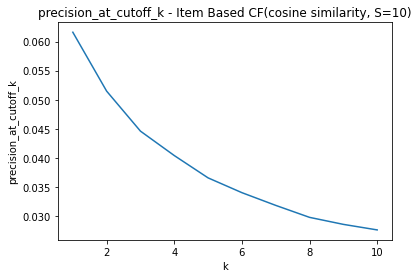

In [44]:
plt.plot(cosCF_results['cutoff'],cosCF_results['precision'] )
plt.title('precision_at_cutoff_k - Item Based CF(cosine similarity, S=10)')
plt.xlabel('k')
plt.ylabel('precision_at_cutoff_k')
plt.show()

# Item Based CF - Pearson

In [45]:
PearsonCF_s, PearsonCF_train, PearsonCF_val = test_s_vals('pearson')

Preparing data set.

Data has 108626 observations with 9672 users and 14105 items.

Data prepared in: 0.092003s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 875us                          | 10.25      |

| 3.232ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 971.091ms                           | 0                | 0               |

| 1.54s                               | 100              | 14105           |

+-------------------------------------+------------------+-----------------+

PROGRESS: Evaluate model M0


Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.5567s

recommendations finished on 1000/9672 queries. users per second: 13165.7

recommendations finished on 2000/9672 queries. users per second: 13048.1

recommendations finished on 3000/9672 queries. users per second: 12417.2

recommendations finished on 4000/9672 queries. users per second: 11582.9

recommendations finished on 5000/9672 queries. users per second: 10964.5

recommendations finished on 6000/9672 queries. users per second: 10131.6

recommendations finished on 7000/9672 queries. users per second: 10257.9

recommendations finished on 8000/9672 queries. users per second: 10351.8

recommendations finished on 9000/9672 queries. users per second: 10453.8


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    |          0.0           |          0.0           |
|   2    | 5.169561621174526e-05  | 6.461952026468157e-06  |
|   3    | 0.00010339123242349047 | 3.2720042800687966e-05 |
|   4    | 0.00012923904052936316 | 5.2161129239293046e-05 |
|   5    | 0.00014474772539288663 | 7.985520935272793e-05  |
|   6    | 0.00015508684863523565 | 0.00010791854386767542 |
|   7    | 0.00026586316908897576 | 0.00019302702111324933 |
|   8    | 0.00028432588916459903 | 0.00022337861396484217 |
|   9    | 0.0002642220384155868  | 0.00024405686044954038 |
|   10   | 0.00024813895781637766 | 0.00025267279648483133 |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.2028175974168257

Per User RMSE (best)
+-----------+---

recommendations finished on 1000/9672 queries. users per second: 20303.3

recommendations finished on 2000/9672 queries. users per second: 19218.2

recommendations finished on 3000/9672 queries. users per second: 18243.4

recommendations finished on 4000/9672 queries. users per second: 18014

recommendations finished on 5000/9672 queries. users per second: 17876

recommendations finished on 6000/9672 queries. users per second: 17716.3

recommendations finished on 7000/9672 queries. users per second: 17497

recommendations finished on 8000/9672 queries. users per second: 16934.6

recommendations finished on 9000/9672 queries. users per second: 16235.3

Preparing data set.

Data has 108626 observations with 9672 users and 14105 items.

Data prepared in: 0.086884s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.146ms                        | 10.25      |

| 4.699ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 974.925ms                           | 0                | 0               |

| 1.58s                               | 100              | 14105           |

+-------------------------------------+------------------+-----------------+

PROGRESS: Evaluate model M0


Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.59664s

recommendations finished on 1000/9672 queries. users per second: 10560.1

recommendations finished on 2000/9672 queries. users per second: 10477

recommendations finished on 3000/9672 queries. users per second: 10523.1

recommendations finished on 4000/9672 queries. users per second: 10748.1

recommendations finished on 5000/9672 queries. users per second: 10780.1

recommendations finished on 6000/9672 queries. users per second: 10954.3

recommendations finished on 7000/9672 queries. users per second: 10944.6

recommendations finished on 8000/9672 queries. users per second: 11093.2

recommendations finished on 9000/9672 queries. users per second: 11153.8


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    | 0.00020678246484698103 | 2.625809077421981e-05  |
|   2    | 0.00015508684863523562 | 3.272004280068795e-05  |
|   3    | 0.00010339123242349053 | 3.272004280068791e-05  |
|   4    | 0.00015508684863523592 | 6.636322160515706e-05  |
|   5    | 0.00012406947890818875 | 6.636322160515701e-05  |
|   6    | 0.0001550868486352358  | 0.00010791854386767539 |
|   7    | 0.00033971404939146853 | 0.00024413518714076944 |
|   8    | 0.0003618693134822167  | 0.00029890792336511885 |
|   9    | 0.0003791011855527987  | 0.0003467112526837289  |
|   10   | 0.0003928866832092643  | 0.0003970261099154591  |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.19464418269678435

Per User RMSE (best)
+-----------+--

recommendations finished on 1000/9672 queries. users per second: 18297.6

recommendations finished on 2000/9672 queries. users per second: 18005.2

recommendations finished on 3000/9672 queries. users per second: 17838

recommendations finished on 4000/9672 queries. users per second: 17516.4

recommendations finished on 5000/9672 queries. users per second: 17287.8

recommendations finished on 6000/9672 queries. users per second: 17309.6

recommendations finished on 7000/9672 queries. users per second: 16399

recommendations finished on 8000/9672 queries. users per second: 16331.7

recommendations finished on 9000/9672 queries. users per second: 16164.6

Preparing data set.

Data has 108626 observations with 9672 users and 14105 items.

Data prepared in: 0.080498s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.06ms                         | 10.25      |

| 4.75ms                         | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 985.452ms                           | 0                | 0               |

| 1.61s                               | 100              | 14105           |

+-------------------------------------+------------------+-----------------+

PROGRESS: Evaluate model M0


Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.62101s

recommendations finished on 1000/9672 queries. users per second: 9444.21

recommendations finished on 2000/9672 queries. users per second: 10613.1

recommendations finished on 3000/9672 queries. users per second: 10847.7

recommendations finished on 4000/9672 queries. users per second: 10738.8

recommendations finished on 5000/9672 queries. users per second: 10784.6

recommendations finished on 6000/9672 queries. users per second: 10926.2

recommendations finished on 7000/9672 queries. users per second: 11036.6

recommendations finished on 8000/9672 queries. users per second: 11113.3

recommendations finished on 9000/9672 queries. users per second: 11143.9


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    | 0.00010339123242349052 | 1.4770176060498651e-05 |
|   2    | 5.169561621174526e-05  | 1.477017606049865e-05  |
|   3    | 0.00010339123242349037 | 3.2720042800687946e-05 |
|   4    | 0.00018093465674110822 | 7.103413198326354e-05  |
|   5    | 0.00014474772539288674 | 7.103413198326347e-05  |
|   6    | 0.00018955059277639925 | 0.00012735963030628022 |
|   7    | 0.00038402457757296456 | 0.0002750641882930966  |
|   8    | 0.00043941273779983465 | 0.00035011650822755025 |
|   9    | 0.0004710045032625684  | 0.00042381747755507095 |
|   10   | 0.0004652605459057068  | 0.0004633071843834869  |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.1902934968557258

Per User RMSE (best)
+-----------+---

recommendations finished on 1000/9672 queries. users per second: 20543.2

recommendations finished on 2000/9672 queries. users per second: 19640.4

recommendations finished on 3000/9672 queries. users per second: 18457.6

recommendations finished on 4000/9672 queries. users per second: 18201.1

recommendations finished on 5000/9672 queries. users per second: 17867.4

recommendations finished on 6000/9672 queries. users per second: 17835.4

recommendations finished on 7000/9672 queries. users per second: 17789.3

recommendations finished on 8000/9672 queries. users per second: 17613

recommendations finished on 9000/9672 queries. users per second: 17543.5

Preparing data set.

Data has 108626 observations with 9672 users and 14105 items.

Data prepared in: 0.087144s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.087ms                        | 10.25      |

| 4.309ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 977.817ms                           | 0                | 0               |

| 1.58s                               | 100              | 14105           |

+-------------------------------------+------------------+-----------------+

PROGRESS: Evaluate model M0

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.59699s

recommendations finished on 1000/9672 queries. users per second: 12733.2

recommendations finished on 2000/9672 queries. users per second: 12968.2

recommendations finished on 3000/9672 queries. users per second: 12634.7

recommendations finished on 4000/9672 queries. users per second: 12525

recommendations finished on 5000/9672 queries. users per second: 12391.3

recommendations finished on 6000/9672 queries. users per second: 12324.6

recommendations finished on 7000/9672 queries. users per second: 12299.6

recommendations finished on 8000/9672 queries. users per second: 12254.2

recommendations finished on 9000/9672 queries. users per second: 12190.2


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    | 0.00010339123242349045 | 6.461952026468153e-06  |
|   2    | 5.169561621174507e-05  | 6.4619520264681335e-06 |
|   3    | 0.00010339123242349052 | 3.272004280068797e-05  |
|   4    | 0.0001809346567411085  | 7.103413198326339e-05  |
|   5    | 0.00014474772539288685 | 7.103413198326348e-05  |
|   6    | 0.00018955059277639925 | 0.0001273596303062805  |
|   7    | 0.0003840245775729643  | 0.0002750641882930972  |
|   8    | 0.0004394127377998343  |  0.00035011650822755   |
|   9    | 0.00043654075912140437 | 0.00039247819373439753 |
|   10   | 0.00042390405293631095 | 0.00042335196452752255 |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.18809659042502902

Per User RMSE (best)
+-----------+--

recommendations finished on 1000/9672 queries. users per second: 17540.5

recommendations finished on 2000/9672 queries. users per second: 17873.3

recommendations finished on 3000/9672 queries. users per second: 17552.5

recommendations finished on 4000/9672 queries. users per second: 17647.6

recommendations finished on 5000/9672 queries. users per second: 17133.8

recommendations finished on 6000/9672 queries. users per second: 17136.3

recommendations finished on 7000/9672 queries. users per second: 17264.1

recommendations finished on 8000/9672 queries. users per second: 17213.1

recommendations finished on 9000/9672 queries. users per second: 17177.9

Preparing data set.

Data has 108626 observations with 9672 users and 14105 items.

Data prepared in: 0.085939s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.143ms                        | 10.25      |

| 4.147ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 937.863ms                           | 0                | 0               |

| 1.56s                               | 100              | 14105           |

+-------------------------------------+------------------+-----------------+

PROGRESS: Evaluate model M0


Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.57802s

recommendations finished on 1000/9672 queries. users per second: 11111.1

recommendations finished on 2000/9672 queries. users per second: 8340.81

recommendations finished on 3000/9672 queries. users per second: 8153.84

recommendations finished on 4000/9672 queries. users per second: 8063.07

recommendations finished on 5000/9672 queries. users per second: 8197.7

recommendations finished on 6000/9672 queries. users per second: 8221.85

recommendations finished on 7000/9672 queries. users per second: 8308.31

recommendations finished on 8000/9672 queries. users per second: 8323.06

recommendations finished on 9000/9672 queries. users per second: 8538.97


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    |          0.0           |          0.0           |
|   2    | 0.00010339123242349052 | 1.794986674018932e-05  |
|   3    | 0.00010339123242349056 | 3.272004280068797e-05  |
|   4    | 0.00020678246484698095 |  7.74960840097316e-05  |
|   5    | 0.00018610421836228272 | 9.226626007023034e-05  |
|   6    | 0.0002067824648469807  | 0.0001338215823327486  |
|   7    | 0.0003840245775729644  | 0.00027506418829309617 |
|   8    | 0.00046526054590570736 | 0.0003602224181636809  |
|   9    | 0.00047100450326256776 | 0.0004105372753954114  |
|   10   | 0.00046526054590570703 | 0.0004543349502414732  |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.1867861307267483

Per User RMSE (best)
+-----------+---

recommendations finished on 1000/9672 queries. users per second: 19355.5

recommendations finished on 2000/9672 queries. users per second: 18579.8

recommendations finished on 3000/9672 queries. users per second: 18489

recommendations finished on 4000/9672 queries. users per second: 17650.5

recommendations finished on 5000/9672 queries. users per second: 17046.8

recommendations finished on 6000/9672 queries. users per second: 16814.7

recommendations finished on 7000/9672 queries. users per second: 16842.2

recommendations finished on 8000/9672 queries. users per second: 16813.3

recommendations finished on 9000/9672 queries. users per second: 16912.5

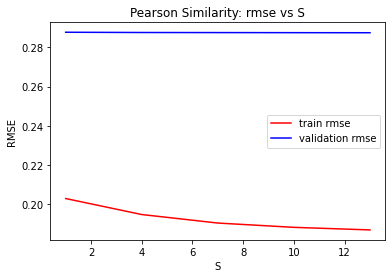

In [46]:
plt.plot(PearsonCF_s,PearsonCF_train, color= 'r' ,label='train rmse' )
plt.plot(PearsonCF_s,PearsonCF_val, color= 'b',label='validation rmse' )
plt.xlabel('S')
plt.ylabel('RMSE')
plt.title('Pearson Similarity: rmse vs S')
plt.legend()
plt.show()

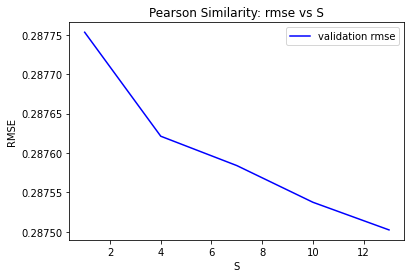

In [47]:
plt.plot(PearsonCF_s,PearsonCF_val, color= 'b',label='validation rmse' )
plt.xlabel('S')
plt.ylabel('RMSE')
plt.title('Pearson Similarity: rmse vs S')
plt.legend()
plt.show()

In [48]:
PearsonCF_model = tc.item_similarity_recommender.create(train_data,similarity_type='pearson',user_id=user_id, item_id=item_id,target = target,only_top_k=10)


Preparing data set.

Data has 144830 observations with 9672 users and 15079 items.

Data prepared in: 0.104373s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.064ms                        | 10.25      |

| 5.307ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.06s                               | 0                | 2               |

| 1.77s                               | 100              | 15079           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

In [49]:
PearsonCF_evaluation = PearsonCF_model.evaluate_precision_recall(test,cutoffs = list(range(1, 11)))

Generating candidate set for working with new users.

Finished training in 1.79045s

recommendations finished on 1000/9255 queries. users per second: 14429.8

recommendations finished on 2000/9255 queries. users per second: 15448.7

recommendations finished on 3000/9255 queries. users per second: 14950.7

recommendations finished on 4000/9255 queries. users per second: 14929.8

recommendations finished on 5000/9255 queries. users per second: 14833.1

recommendations finished on 6000/9255 queries. users per second: 14171.3

recommendations finished on 7000/9255 queries. users per second: 13777.6

recommendations finished on 8000/9255 queries. users per second: 13288.4

recommendations finished on 9000/9255 queries. users per second: 12624.6

In [50]:
col_names =  ['cutoff', 'precision', 'recall'] 
PearsonCF_results  = pd.DataFrame(columns = col_names)
PearsonCF_results['cutoff'] = np.array(PearsonCF_evaluation['precision_recall_overall']['cutoff'])
PearsonCF_results['precision'] = np.array(PearsonCF_evaluation['precision_recall_overall']['precision'])
PearsonCF_results['recall'] = np.array(PearsonCF_evaluation['precision_recall_overall']['recall'])

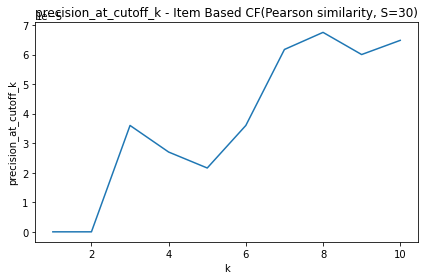

In [51]:
plt.plot(PearsonCF_results['cutoff'],PearsonCF_results['precision'] )
plt.title('precision_at_cutoff_k - Item Based CF(Pearson similarity, S=30)')
plt.xlabel('k')
plt.ylabel('precision_at_cutoff_k')
plt.tight_layout()
plt.show()

# Item Based CF - Jaccard

In [52]:
JaccardCF_s, JaccardCF_train, JaccardCF_val = test_s_vals('jaccard')

Preparing data set.

Data has 108626 observations with 9672 users and 14105 items.

Data prepared in: 0.084556s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.75ms                         | 10.25      |

| 4.745ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 908.98ms                            | 0                | 0               |

| 1.54s                               | 100              | 14105           |

+-------------------------------------+------------------+-----------------+

PROGRESS: Evaluate model M0


Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.57195s

recommendations finished on 1000/9672 queries. users per second: 16897.6

recommendations finished on 2000/9672 queries. users per second: 14921.8

recommendations finished on 3000/9672 queries. users per second: 11531.9

recommendations finished on 4000/9672 queries. users per second: 11993.4

recommendations finished on 5000/9672 queries. users per second: 11583.3

recommendations finished on 6000/9672 queries. users per second: 11150.2

recommendations finished on 7000/9672 queries. users per second: 11123.6

recommendations finished on 8000/9672 queries. users per second: 11171.2

recommendations finished on 9000/9672 queries. users per second: 11250.1


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    | 0.31110421836228286 | 0.029307823867767566 |
|   2    |  0.327388337468983  | 0.06352324820574656  |
|   3    |  0.285945685139234  |  0.0830589830446024  |
|   4    | 0.25958953680727903 | 0.10008388894898082  |
|   5    |  0.2393920595533498 | 0.11456356576985667  |
|   6    | 0.22175696167631662 | 0.12627413779875774  |
|   7    | 0.20598487533971405 | 0.13515134701464798  |
|   8    | 0.19190705128205124 |  0.1418439813299993  |
|   9    | 0.17864856171307764 | 0.14659974063410144  |
|   10   |  0.1672663358147229 | 0.15053548628507665  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.059010834479865

Per User RMSE (best)
+-----------+------+-------+
|  user_id  | rmse | count |
+-----------+------+-------+


recommendations finished on 1000/9672 queries. users per second: 14514.2

recommendations finished on 2000/9672 queries. users per second: 14535

recommendations finished on 3000/9672 queries. users per second: 15199

recommendations finished on 4000/9672 queries. users per second: 16039.8

recommendations finished on 5000/9672 queries. users per second: 16386

recommendations finished on 6000/9672 queries. users per second: 16568.5

recommendations finished on 7000/9672 queries. users per second: 16833.2

recommendations finished on 8000/9672 queries. users per second: 16927.1

recommendations finished on 9000/9672 queries. users per second: 16958.4

Preparing data set.

Data has 108626 observations with 9672 users and 14105 items.

Data prepared in: 0.080845s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.052ms                        | 10.25      |

| 3.295ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 961.996ms                           | 0                | 0               |

| 1.65s                               | 100              | 14105           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

PROGRESS: Evaluate model M0


Generating candidate set for working with new users.

Finished training in 1.67008s

recommendations finished on 1000/9672 queries. users per second: 17648.8

recommendations finished on 2000/9672 queries. users per second: 16657.8

recommendations finished on 3000/9672 queries. users per second: 16390.6

recommendations finished on 4000/9672 queries. users per second: 15125.4

recommendations finished on 5000/9672 queries. users per second: 14337.8

recommendations finished on 6000/9672 queries. users per second: 14194.3

recommendations finished on 7000/9672 queries. users per second: 14175.5

recommendations finished on 8000/9672 queries. users per second: 13623.2

recommendations finished on 9000/9672 queries. users per second: 13365.4


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.3843052109181141 | 0.03545616683802317 |
|   2    |  0.3748966087675768 | 0.06970801505154285 |
|   3    |  0.3553901295836784 | 0.09899659185798464 |
|   4    | 0.33439309346567414 |  0.1238139297836795 |
|   5    |  0.3131100082712981 | 0.14458947422728796 |
|   6    | 0.28827198786876196 |  0.1600057853175069 |
|   7    |  0.2689649060616799 | 0.17432297358397159 |
|   8    |  0.252041976840364  |  0.1867875328311513 |
|   9    | 0.23825935116257724 |  0.198755931020675  |
|   10   | 0.22645781637717127 |  0.2103564232403975 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 1.050604207443279

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------+

recommendations finished on 1000/9672 queries. users per second: 19007.4

recommendations finished on 2000/9672 queries. users per second: 18993.2

recommendations finished on 3000/9672 queries. users per second: 18175.9

recommendations finished on 4000/9672 queries. users per second: 17799.5

recommendations finished on 5000/9672 queries. users per second: 17822.5

recommendations finished on 6000/9672 queries. users per second: 17711.9

recommendations finished on 7000/9672 queries. users per second: 17546.8

recommendations finished on 8000/9672 queries. users per second: 17273.9

recommendations finished on 9000/9672 queries. users per second: 17328.9

Preparing data set.

Data has 108626 observations with 9672 users and 14105 items.

Data prepared in: 0.088639s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 739us                          | 10.25      |

| 2.833ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 955.407ms                           | 0                | 0               |

| 1.68s                               | 100              | 14105           |

+-------------------------------------+------------------+-----------------+

PROGRESS: Evaluate model M0


Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.69809s

recommendations finished on 1000/9672 queries. users per second: 15490.2

recommendations finished on 2000/9672 queries. users per second: 15310.4

recommendations finished on 3000/9672 queries. users per second: 15383.9

recommendations finished on 4000/9672 queries. users per second: 12903.3

recommendations finished on 5000/9672 queries. users per second: 13182.2

recommendations finished on 6000/9672 queries. users per second: 13399.5

recommendations finished on 7000/9672 queries. users per second: 13644.8

recommendations finished on 8000/9672 queries. users per second: 13295.2

recommendations finished on 9000/9672 queries. users per second: 13142


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.42524813895781677 | 0.03964602863462505 |
|   2    | 0.41123862696443364 | 0.07664998330863185 |
|   3    | 0.39423076923076983 | 0.11000630524252895 |
|   4    |  0.3737334574028121 | 0.13823437974947156 |
|   5    |  0.3505376344086023 | 0.16086551158124526 |
|   6    |  0.3284567135373591 |  0.1797562524876184 |
|   7    | 0.30862282878411973 | 0.19570747410584105 |
|   8    |  0.2901545698924735 | 0.20902888942125183 |
|   9    | 0.27350427350427337 |  0.2215475438920444 |
|   10   | 0.25927419354838677 | 0.23327962781201958 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 1.045912189803828

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+--

recommendations finished on 1000/9672 queries. users per second: 16555.5

recommendations finished on 2000/9672 queries. users per second: 17039

recommendations finished on 3000/9672 queries. users per second: 16964.6

recommendations finished on 4000/9672 queries. users per second: 17046.4

recommendations finished on 5000/9672 queries. users per second: 17161.1

recommendations finished on 6000/9672 queries. users per second: 17134.8

recommendations finished on 7000/9672 queries. users per second: 17191.9

recommendations finished on 8000/9672 queries. users per second: 17126

recommendations finished on 9000/9672 queries. users per second: 17239.7

Preparing data set.

Data has 108626 observations with 9672 users and 14105 items.

Data prepared in: 0.102784s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 886us                          | 10.25      |

| 3.098ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 981.478ms                           | 0                | 0               |

| 1.66s                               | 100              | 14105           |

+-------------------------------------+------------------+-----------------+

PROGRESS: Evaluate model M0


Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.67487s

recommendations finished on 1000/9672 queries. users per second: 16553.3

recommendations finished on 2000/9672 queries. users per second: 16823

recommendations finished on 3000/9672 queries. users per second: 16147.3

recommendations finished on 4000/9672 queries. users per second: 15674.3

recommendations finished on 5000/9672 queries. users per second: 15626.9

recommendations finished on 6000/9672 queries. users per second: 15299.6

recommendations finished on 7000/9672 queries. users per second: 15263.3

recommendations finished on 8000/9672 queries. users per second: 15173.4

recommendations finished on 9000/9672 queries. users per second: 15086.5


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.4508891645988422 | 0.04196329682505654 |
|   2    |  0.4402398676592225 | 0.08218629612857813 |
|   3    |  0.4208023159636062 | 0.11752436847658855 |
|   4    |  0.4003825475599666 |  0.1482481741615017 |
|   5    |  0.3781017369727051 | 0.17365035708441565 |
|   6    | 0.35535566583953687 | 0.19429327509793146 |
|   7    |  0.3342933947772648 | 0.21145010555326152 |
|   8    |  0.3158085194375523 | 0.22689823979337467 |
|   9    | 0.29815733847991976 | 0.23966865979088822 |
|   10   |  0.2826716294458225 |  0.2513665724872429 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0427883347460278

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

recommendations finished on 1000/9672 queries. users per second: 20840.3

recommendations finished on 2000/9672 queries. users per second: 20677.2

recommendations finished on 3000/9672 queries. users per second: 19243.2

recommendations finished on 4000/9672 queries. users per second: 18058.4

recommendations finished on 5000/9672 queries. users per second: 17414.3

recommendations finished on 6000/9672 queries. users per second: 17362.7

recommendations finished on 7000/9672 queries. users per second: 17058.7

recommendations finished on 8000/9672 queries. users per second: 17071.1

recommendations finished on 9000/9672 queries. users per second: 17267.8

Preparing data set.

Data has 108626 observations with 9672 users and 14105 items.

Data prepared in: 0.099274s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.274ms                        | 10.25      |

| 4.17ms                         | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.18s                               | 0                | 0               |

| 2.02s                               | 100              | 14105           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

PROGRESS: Evaluate model M0


Generating candidate set for working with new users.

Finished training in 2.03987s

recommendations finished on 1000/9672 queries. users per second: 16571.9

recommendations finished on 2000/9672 queries. users per second: 16291.3

recommendations finished on 3000/9672 queries. users per second: 15917.4

recommendations finished on 4000/9672 queries. users per second: 15832.4

recommendations finished on 5000/9672 queries. users per second: 15517

recommendations finished on 6000/9672 queries. users per second: 15390.8

recommendations finished on 7000/9672 queries. users per second: 15457.1

recommendations finished on 8000/9672 queries. users per second: 14892.3

recommendations finished on 9000/9672 queries. users per second: 14910.4


Precision and recall summary statistics by cutoff
+--------+---------------------+----------------------+
| cutoff |    mean_precision   |     mean_recall      |
+--------+---------------------+----------------------+
|   1    |  0.4684656741108354 | 0.043778831190870005 |
|   2    |  0.4601426799007443 | 0.08629817301351321  |
|   3    | 0.44134270747173965 |  0.1236471115980389  |
|   4    |  0.420414598842018  | 0.15584443474009693  |
|   5    |  0.3977253928866831 | 0.18291773995843255  |
|   6    | 0.37593052109181146 | 0.20563501475478602  |
|   7    | 0.35575446059317023 | 0.22538418847896527  |
|   8    | 0.33576302729528595 | 0.24131616788622293  |
|   9    | 0.31775572098152727 | 0.25534028276354864  |
|   10   |  0.3016439205955332 |  0.2677092890064034  |
+--------+---------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.040400914483112

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+

recommendations finished on 1000/9672 queries. users per second: 21232.8

recommendations finished on 2000/9672 queries. users per second: 21262.6

recommendations finished on 3000/9672 queries. users per second: 19763.5

recommendations finished on 4000/9672 queries. users per second: 18924.8

recommendations finished on 5000/9672 queries. users per second: 18605

recommendations finished on 6000/9672 queries. users per second: 18617.5

recommendations finished on 7000/9672 queries. users per second: 18621.8

recommendations finished on 8000/9672 queries. users per second: 18464.4

recommendations finished on 9000/9672 queries. users per second: 18475.3

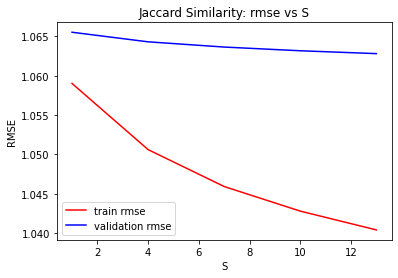

In [53]:
plt.plot(JaccardCF_s,JaccardCF_train, color= 'r' ,label='train rmse' )
plt.plot(JaccardCF_s,JaccardCF_val, color= 'b',label='validation rmse' )
plt.xlabel('S')
plt.ylabel('RMSE')
plt.title('Jaccard Similarity: rmse vs S')
plt.legend()
plt.show()

In [54]:
JaccardCF_model = tc.item_similarity_recommender.create(train_data,similarity_type='jaccard',user_id=user_id, item_id=item_id,target = target,only_top_k=10)

Preparing data set.

Data has 144830 observations with 9672 users and 15079 items.

Data prepared in: 0.118664s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.069ms                        | 10.25      |

| 3.488ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1.07s                               | 0                | 0               |

| 1.98s                               | 100              | 15079           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

In [55]:
JaccardCF_evaluation = JaccardCF_model.evaluate_precision_recall(test,cutoffs = list(range(1, 11)))

Finished training in 1.99651s

recommendations finished on 1000/9255 queries. users per second: 12839.4

recommendations finished on 2000/9255 queries. users per second: 13385.1

recommendations finished on 3000/9255 queries. users per second: 12816.5

recommendations finished on 4000/9255 queries. users per second: 12750.3

recommendations finished on 5000/9255 queries. users per second: 12536.5

recommendations finished on 6000/9255 queries. users per second: 12508.7

recommendations finished on 7000/9255 queries. users per second: 12296.4

recommendations finished on 8000/9255 queries. users per second: 12463.2

recommendations finished on 9000/9255 queries. users per second: 12422.2

In [56]:
col_names =  ['cutoff', 'precision', 'recall'] 
JaccardCF_results  = pd.DataFrame(columns = col_names)
JaccardCF_results['cutoff'] = np.array(JaccardCF_evaluation['precision_recall_overall']['cutoff'])
JaccardCF_results['precision'] = np.array(JaccardCF_evaluation['precision_recall_overall']['precision'])
JaccardCF_results['recall'] = np.array(JaccardCF_evaluation['precision_recall_overall']['recall'])

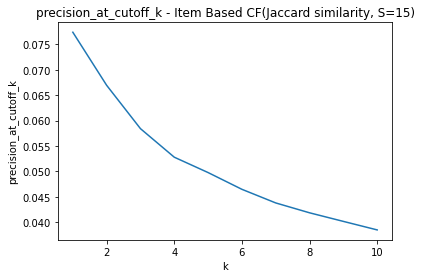

In [57]:
plt.plot(JaccardCF_results['cutoff'],JaccardCF_results['precision'] )
plt.title('precision_at_cutoff_k - Item Based CF(Jaccard similarity, S=15)')
plt.xlabel('k')
plt.ylabel('precision_at_cutoff_k')
plt.show()

# Matrix Factorization iALS



In [58]:

user_id = 'user_id'
item_id = 'product_id'
target = 'purchase_count'

In [59]:

num_features = np.arange(10,200,20)
def test_k_vals():
    k_list = []
    train = []
    val = []
    for loc, k in enumerate(num_features):
        model = tc.ranking_factorization_recommender.create(train_val,item_id = item_id, target = target,\
                                                                   user_id = user_id, binary_target = False,\
                                                                   solver = 'ials', num_factors = k)
        rmse_train = tc.recommender.util.compare_models(train_val, [model],exclude_known_for_precision_recall=False)
        rmse_train = rmse_train[0]['rmse_overall']
        k_list.append(k)
        train.append(rmse_train)
        rmse_val = tc.recommender.util.compare_models(validation, [model], model_names=["m1"], metric='rmse')
        rmse_val = rmse_val[0]['rmse_overall']
        val.append(rmse_val)
    return k_list,train,val

In [ ]:
ials_k, ials_train_k, ials_val_k = test_k_vals() 

Preparing data set.

Data has 108626 observations with 9672 users and 14105 items.

Data prepared in: 0.096328s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 10       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 80us         | NA                        |

+---------+--------------+---------------------------+

| 0       | 91.74ms      | 1.04918                   |

| 1       | 145.843ms    | 1.0182                    |

| 2       | 210.279ms    | 1.01149                   |

| 3       | 266.088ms    | 1.00931                   |

| 4       | 331.715ms    | 1.00824                   |

| 5       | 392.68ms     | 1.00761                   |

| 6       | 447.754ms    | 1.00723                   |

| 7       | 507.136ms    | 1.00699                   |

| 8       | 572.782ms    | 1.00683                   |

| 9       | 638.152ms    | 1.00672                   |

| 10      | 719.545ms    | 1.00663                   |

| 11      | 782.804ms    | 1.00657                   |

| 12      | 853.416ms    | 1.00653                   |

| 13      | 916.231ms    | 1.00649                   |

| 14      | 976.689ms    | 1.00646                   |

| 15      | 1.03s        | 1.00644                   |

| 16      | 1.09s        | 1.00642                   |

| 17      | 1.17s        | 1.0064                    |

| 18      | 1.24s        | 1.00638                   |

| 19      | 1.32s        | 1.00637                   |

| 20      | 1.39s        | 1.00636                   |

| 21      | 1.45s        | 1.00635                   |

| 22      | 1.51s        | 1.00634                   |

| 23      | 1.57s        | 1.00633                   |

| 24      | 1.63s        | 1.00632                   |

| FINAL   | 1.68s        | 1.00632                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/9672 queries. users per second: 10142

recommendations finished on 2000/9672 queries. users per second: 8383.85

recommendations finished on 3000/9672 queries. users per second: 7975.05

recommendations finished on 4000/9672 queries. users per second: 7887.18

recommendations finished on 5000/9672 queries. users per second: 7973.87

recommendations finished on 6000/9672 queries. users per second: 8092.28

recommendations finished on 7000/9672 queries. users per second: 8172.87

recommendations finished on 8000/9672 queries. users per second: 7862.93

recommendations finished on 9000/9672 queries. users per second: 7776.51


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.31627377998345785 | 0.03185969485777448 |
|   2    | 0.25553143093465697 | 0.05120985154221867 |
|   3    | 0.21543286462641287 | 0.06398177348380156 |
|   4    | 0.18876654259718773 | 0.07463012666165282 |
|   5    |  0.1695616211745244 | 0.08354490496600699 |
|   6    | 0.15496622553074169 | 0.09150329670332732 |
|   7    | 0.14287191303320362 | 0.09814648794613935 |
|   8    | 0.13293527708850275 | 0.10412982746048051 |
|   9    |  0.1250574395735685 | 0.10986609249238281 |
|   10   | 0.11786600496277896 | 0.11469292243456024 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0063234263465128

Per User RMSE (best)
+-----------+-------------------+-------+
|  user_id  |        rmse       | count |
+-----------+---

Preparing data set.

Data has 108626 observations with 9672 users and 14105 items.

Data prepared in: 0.083471s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 30       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 101us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 223.23ms     | 1.02269                   |

| 1       | 434.174ms    | 0.976795                  |

| 2       | 620.664ms    | 0.969149                  |

| 3       | 820.563ms    | 0.966292                  |

| 4       | 1.00s        | 0.964893                  |

| 5       | 1.19s        | 0.964082                  |

| 6       | 1.39s        | 0.963559                  |

| 7       | 1.62s        | 0.963197                  |

| 8       | 1.83s        | 0.962936                  |

| 9       | 2.01s        | 0.962743                  |

| 10      | 2.23s        | 0.962596                  |

| 11      | 2.41s        | 0.962482                  |

| 12      | 2.59s        | 0.962393                  |

| 13      | 2.76s        | 0.962321                  |

| 14      | 2.93s        | 0.962263                  |

| 15      | 3.10s        | 0.962216                  |

| 16      | 3.30s        | 0.962176                  |

| 17      | 3.50s        | 0.962142                  |

| 18      | 3.68s        | 0.962114                  |

| 19      | 3.85s        | 0.96209                   |

| 20      | 4.02s        | 0.962069                  |

| 21      | 4.19s        | 0.962051                  |

| 22      | 4.36s        | 0.962035                  |

| 23      | 4.53s        | 0.962021                  |

| 24      | 4.70s        | 0.962009                  |

| FINAL   | 4.70s        | 0.962009                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/9672 queries. users per second: 7314.17

recommendations finished on 2000/9672 queries. users per second: 6961.44

recommendations finished on 3000/9672 queries. users per second: 7029.86

recommendations finished on 4000/9672 queries. users per second: 6477.31

recommendations finished on 5000/9672 queries. users per second: 6545.7

recommendations finished on 6000/9672 queries. users per second: 6621.04

recommendations finished on 7000/9672 queries. users per second: 6626.26

recommendations finished on 8000/9672 queries. users per second: 6657.98

recommendations finished on 9000/9672 queries. users per second: 6609.86


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.594292803970223  | 0.06297394988529655 |
|   2    |  0.4776157981803143 | 0.09870008551338708 |
|   3    |  0.3973325062034741 | 0.12109583989023584 |
|   4    | 0.33982113316790696 | 0.13615276324912173 |
|   5    | 0.30095119933829606 | 0.14968162442233887 |
|   6    | 0.27121243451888566 |  0.1609709518835672 |
|   7    | 0.24750384024577532 | 0.17060806568991263 |
|   8    | 0.22796474358974358 |  0.1785917579769433 |
|   9    | 0.21212434518886153 | 0.18621945498481793 |
|   10   | 0.19774607113316767 | 0.19209652548591843 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.9620085068544337

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

Preparing data set.

Data has 108626 observations with 9672 users and 14105 items.

Data prepared in: 0.093984s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 50       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 116us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 419.311ms    | 1.00254                   |

| 1       | 773.515ms    | 0.947935                  |

| 2       | 1.19s        | 0.939087                  |

| 3       | 1.56s        | 0.935909                  |

| 4       | 1.97s        | 0.934308                  |

| 5       | 2.34s        | 0.933357                  |

| 6       | 2.75s        | 0.932736                  |

| 7       | 3.12s        | 0.932305                  |

| 8       | 3.47s        | 0.931993                  |

| 9       | 3.85s        | 0.93176                   |

| 10      | 4.24s        | 0.93158                   |

| 11      | 4.67s        | 0.931439                  |

| 12      | 5.07s        | 0.931326                  |

| 13      | 5.46s        | 0.931234                  |

| 14      | 5.85s        | 0.931158                  |

| 15      | 6.23s        | 0.931095                  |

| 16      | 6.62s        | 0.931042                  |

| 17      | 7.03s        | 0.930997                  |

| 18      | 7.47s        | 0.930959                  |

| 19      | 7.88s        | 0.930926                  |

| 20      | 8.29s        | 0.930897                  |

| 21      | 8.67s        | 0.930871                  |

| 22      | 9.07s        | 0.930849                  |

| 23      | 9.44s        | 0.930828                  |

| 24      | 9.85s        | 0.93081                   |

| FINAL   | 9.85s        | 0.93081                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/9672 queries. users per second: 5284.27

recommendations finished on 2000/9672 queries. users per second: 4715.72

recommendations finished on 3000/9672 queries. users per second: 4982.36

recommendations finished on 4000/9672 queries. users per second: 5154.47

recommendations finished on 5000/9672 queries. users per second: 5078.31

recommendations finished on 6000/9672 queries. users per second: 5110.04

recommendations finished on 7000/9672 queries. users per second: 5175.95

recommendations finished on 8000/9672 queries. users per second: 5248.92

recommendations finished on 9000/9672 queries. users per second: 5304.47


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.7133995037220843 |  0.0773658334243408 |
|   2    |  0.5950682382133993 | 0.12533111258488447 |
|   3    |  0.5089950372208432 |  0.1569387488043461 |
|   4    |  0.4401623242349048 | 0.17793176614201459 |
|   5    |  0.390095119933829  |  0.1946496103020907 |
|   6    | 0.35070306038047866 | 0.20795399165071157 |
|   7    | 0.31848930639253215 |  0.2186638717466004 |
|   8    | 0.29183467741935537 |  0.2275106330383671 |
|   9    | 0.27026468155500466 | 0.23593875004672113 |
|   10   | 0.25235732009925554 |  0.2441103091460347 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.9308104482351113

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

Preparing data set.

Data has 108626 observations with 9672 users and 14105 items.

Data prepared in: 0.09407s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 70       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 206us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 793.329ms    | 0.981417                  |

| 1       | 1.50s        | 0.923231                  |

| 2       | 2.20s        | 0.913815                  |

| 3       | 2.93s        | 0.910544                  |

| 4       | 3.65s        | 0.908917                  |

| 5       | 4.35s        | 0.907951                  |

| 6       | 5.06s        | 0.907316                  |

| 7       | 5.78s        | 0.906871                  |

| 8       | 6.53s        | 0.906545                  |

| 9       | 7.31s        | 0.906299                  |

| 10      | 8.00s        | 0.906107                  |

| 11      | 8.74s        | 0.905955                  |

| 12      | 9.47s        | 0.905833                  |

| 13      | 10.20s       | 0.905732                  |

| 14      | 10.92s       | 0.905648                  |

| 15      | 11.69s       | 0.905577                  |

| 16      | 12.44s       | 0.905517                  |

| 17      | 13.20s       | 0.905465                  |

| 18      | 13.95s       | 0.90542                   |

| 19      | 14.61s       | 0.905381                  |

| 20      | 15.38s       | 0.905346                  |

| 21      | 16.11s       | 0.905316                  |

| 22      | 16.93s       | 0.905288                  |

| 23      | 17.70s       | 0.905264                  |

| 24      | 18.40s       | 0.905242                  |

| FINAL   | 18.40s       | 0.905242                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/9672 queries. users per second: 4470.65

recommendations finished on 2000/9672 queries. users per second: 4450.78

recommendations finished on 3000/9672 queries. users per second: 4467.81

recommendations finished on 4000/9672 queries. users per second: 4507.66

recommendations finished on 5000/9672 queries. users per second: 4508.1

recommendations finished on 6000/9672 queries. users per second: 4511.64

recommendations finished on 7000/9672 queries. users per second: 4531.5

recommendations finished on 8000/9672 queries. users per second: 4498.03

recommendations finished on 9000/9672 queries. users per second: 4493.65


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.7717121588089328 | 0.08462600529016309 |
|   2    |  0.669096360628618  |  0.1427191655193202 |
|   3    |  0.5832299421009106 | 0.18173968386638692 |
|   4    |  0.514293837882548  | 0.20967260963170634 |
|   5    |  0.4584160463192714 | 0.23011097044937168 |
|   6    | 0.41370278467052707 |  0.2464027464971466 |
|   7    |  0.3771121351766515 | 0.25977926915783517 |
|   8    |  0.3457661290322583 |  0.270336165746749  |
|   9    |  0.3201337193272675 | 0.27995921987576616 |
|   10   | 0.29811827956989284 |  0.2885642602380727 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.9052415292891637

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 108626 observations with 9672 users and 14105 items.

Data prepared in: 0.095006s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 90       |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 164us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 1.21s        | 0.967437                  |

| 1       | 2.39s        | 0.901941                  |

| 2       | 3.55s        | 0.892085                  |

| 3       | 4.77s        | 0.888647                  |

| 4       | 5.97s        | 0.886927                  |

| 5       | 7.12s        | 0.885902                  |

| 6       | 8.18s        | 0.885228                  |

| 7       | 9.36s        | 0.884754                  |

| 8       | 10.49s       | 0.884406                  |

| 9       | 11.64s       | 0.88414                   |

| 10      | 12.77s       | 0.883933                  |

| 11      | 13.91s       | 0.883769                  |

| 12      | 15.02s       | 0.883636                  |

| 13      | 16.11s       | 0.883526                  |

| 14      | 17.24s       | 0.883436                  |

| 15      | 18.38s       | 0.88336                   |

| 16      | 19.60s       | 0.883296                  |

| 17      | 20.99s       | 0.883241                  |

| 18      | 22.14s       | 0.883194                  |

| 19      | 23.34s       | 0.883153                  |

| 20      | 24.52s       | 0.883118                  |

| 21      | 25.68s       | 0.883087                  |

| 22      | 26.78s       | 0.88306                   |

| 23      | 27.94s       | 0.883036                  |

| 24      | 29.09s       | 0.883015                  |

| FINAL   | 29.09s       | 0.883015                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/9672 queries. users per second: 2960.02

recommendations finished on 2000/9672 queries. users per second: 3053.02

recommendations finished on 3000/9672 queries. users per second: 3128.01

recommendations finished on 4000/9672 queries. users per second: 3141.6

recommendations finished on 5000/9672 queries. users per second: 3136.68

recommendations finished on 6000/9672 queries. users per second: 3006.33

recommendations finished on 7000/9672 queries. users per second: 2968.67

recommendations finished on 8000/9672 queries. users per second: 2980.73

recommendations finished on 9000/9672 queries. users per second: 2977.65


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.816894127377999  | 0.09043988874528001 |
|   2    |  0.7239971050454923 | 0.15581520412389108 |
|   3    |  0.6437482768127909 | 0.20273568110848925 |
|   4    |  0.5722963192721264 | 0.23516623112041612 |
|   5    |  0.5145161290322581 |  0.260133477507471  |
|   6    | 0.46560518334711953 | 0.27870337822594105 |
|   7    |  0.4258832565284175 |  0.2942559344521695 |
|   8    |  0.3920854011579816 |  0.3070537843242211 |
|   9    |  0.3642817755720976 | 0.31894861260846563 |
|   10   |  0.3395885028949544 |  0.3284438695666301 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.8830152266986412

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 108626 observations with 9672 users and 14105 items.

Data prepared in: 0.099549s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 110      |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 115us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 1.96s        | 0.949968                  |

| 1       | 3.59s        | 0.882976                  |

| 2       | 5.19s        | 0.872896                  |

| 3       | 6.86s        | 0.869283                  |

| 4       | 8.75s        | 0.867406                  |

| 5       | 10.43s       | 0.866262                  |

| 6       | 12.04s       | 0.865504                  |

| 7       | 13.65s       | 0.864974                  |

| 8       | 15.30s       | 0.864588                  |

| 9       | 16.91s       | 0.864298                  |

| 10      | 18.52s       | 0.864075                  |

| 11      | 20.17s       | 0.863898                  |

| 12      | 22.02s       | 0.863756                  |

| 13      | 23.98s       | 0.863639                  |

| 14      | 25.88s       | 0.863542                  |

| 15      | 27.58s       | 0.86346                   |

| 16      | 29.31s       | 0.863391                  |

| 17      | 31.08s       | 0.863331                  |

| 18      | 32.94s       | 0.863279                  |

| 19      | 34.80s       | 0.863234                  |

| 20      | 36.53s       | 0.863194                  |

| 21      | 38.41s       | 0.86316                   |

| 22      | 40.15s       | 0.863129                  |

| 23      | 42.02s       | 0.863101                  |

| 24      | 43.88s       | 0.863076                  |

| FINAL   | 43.88s       | 0.863076                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/9672 queries. users per second: 2801.18

recommendations finished on 2000/9672 queries. users per second: 2774.34

recommendations finished on 3000/9672 queries. users per second: 2614.02

recommendations finished on 4000/9672 queries. users per second: 2626.21

recommendations finished on 5000/9672 queries. users per second: 2575.76

recommendations finished on 6000/9672 queries. users per second: 2585.24

recommendations finished on 7000/9672 queries. users per second: 2593.12

recommendations finished on 8000/9672 queries. users per second: 2596.96

recommendations finished on 9000/9672 queries. users per second: 2584.24


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.850909842845326  | 0.09514518786163217 |
|   2    |  0.7669561621174522 | 0.16656619238664996 |
|   3    |  0.6884477529638818 |  0.2186705950679969 |
|   4    |  0.6212262200165414 |  0.2576342868468722 |
|   5    |  0.5626964433416061 |  0.286541561299401  |
|   6    |  0.5123035566583956 | 0.30841365738990595 |
|   7    | 0.46979498995628105 |  0.3259485940567166 |
|   8    | 0.43364867659222506 |  0.3405051034099052 |
|   9    |  0.4025480194835036 |  0.352935924191537  |
|   10   |  0.3759098428453264 |  0.3638289542535422 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.8630764116229531

Per User RMSE (best)
+-----------+---------------------+-------+
|  user_id  |         rmse        | count |
+-----------

Preparing data set.

Data has 108626 observations with 9672 users and 14105 items.

Data prepared in: 0.092467s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 130      |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 100us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 2.71s        | 0.93199                   |

| 1       | 5.22s        | 0.865389                  |

| 2       | 7.62s        | 0.855038                  |

| 3       | 10.17s       | 0.851365                  |

| 4       | 12.59s       | 0.849464                  |

| 5       | 14.97s       | 0.848301                  |

| 6       | 17.48s       | 0.847526                  |

| 7       | 19.89s       | 0.846978                  |

| 8       | 22.21s       | 0.846575                  |

| 9       | 24.56s       | 0.846268                  |

| 10      | 26.92s       | 0.846029                  |

| 11      | 29.21s       | 0.845839                  |

| 12      | 31.56s       | 0.845686                  |

| 13      | 34.18s       | 0.84556                   |

| 14      | 36.73s       | 0.845455                  |

| 15      | 39.09s       | 0.845368                  |

| 16      | 41.53s       | 0.845293                  |

| 17      | 43.98s       | 0.84523                   |

| 18      | 46.49s       | 0.845176                  |

| 19      | 49.11s       | 0.845129                  |

| 20      | 51.59s       | 0.845089                  |

| 21      | 54.01s       | 0.845053                  |

| 22      | 56.56s       | 0.845022                  |

| 23      | 59.06s       | 0.844995                  |

| 24      | 1m 1s        | 0.84497                   |

| FINAL   | 1m 1s        | 0.84497                   |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

PROGRESS: Evaluate model M0


recommendations finished on 1000/9672 queries. users per second: 1974.39

recommendations finished on 2000/9672 queries. users per second: 2104.38

recommendations finished on 3000/9672 queries. users per second: 2031.96

recommendations finished on 4000/9672 queries. users per second: 2104.62

recommendations finished on 5000/9672 queries. users per second: 2140.02

recommendations finished on 6000/9672 queries. users per second: 2190.59

recommendations finished on 7000/9672 queries. users per second: 2238.24

recommendations finished on 8000/9672 queries. users per second: 2269.59

recommendations finished on 9000/9672 queries. users per second: 2294.17


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    |  0.8766542597187759 | 0.09853614104151673 |
|   2    |  0.8006617038875096 | 0.17528331363894448 |
|   3    |  0.728184449958644  | 0.23305929364146072 |
|   4    |  0.6624276261373027 |  0.2766769389849912 |
|   5    |  0.6019851116625291 | 0.30809417510453757 |
|   6    |  0.5511958919216983 | 0.33320724179449707 |
|   7    |  0.5078281933120654 |  0.3535180142385451 |
|   8    | 0.46962882547559964 |  0.3695304503901086 |
|   9    |  0.4369198603069565 |  0.3833438175297397 |
|   10   | 0.40852977667493806 | 0.39545520081973135 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.8449702268695719

Per User RMSE (best)
+-----------+--------------------+-------+
|  user_id  |        rmse        | count |
+-----------+-

Preparing data set.

Data has 108626 observations with 9672 users and 14105 items.

Data prepared in: 0.102919s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 150      |

| regularization               | L2 Regularization on Factors                     | 1e-09    |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 112us        | NA                        |

+---------+--------------+---------------------------+

| 0       | 3.55s        | 0.919627                  |

| 1       | 6.84s        | 0.84932                   |

| 2       | 10.13s       | 0.838711                  |

| 3       | 13.30s       | 0.834853                  |

| 4       | 16.60s       | 0.832836                  |

| 5       | 19.98s       | 0.831604                  |

| 6       | 23.37s       | 0.830787                  |

| 7       | 26.97s       | 0.830214                  |

| 8       | 30.44s       | 0.829798                  |

In [ ]:

plt.plot(ials_k, ials_train_k, color= 'r' ,label='train rmse' )
plt.plot(ials_k,  ials_val_k, color= 'b',label='validation rmse' )
plt.xlabel('number of factors ')
plt.ylabel('RMSE')
plt.title('Matrix Factorization(ials): rmse vs number of features')
plt.legend()
plt.show()

In [ ]:

num_scales = np.arange(1,200,2)
def test_scale_vals():
    scale_list = []
    train = []
    val = []
    for loc, scale in enumerate(num_scales):
        model = tc.ranking_factorization_recommender.create(train_val,item_id = item_id, target = target,\
                                                                   user_id = user_id, binary_target = False,\
                                                                   solver = 'ials',num_factors = 70,\
                                                                   ials_confidence_scaling_factor = scale)
        rmse_train = tc.recommender.util.compare_models(train_val, [model],exclude_known_for_precision_recall=False)
        rmse_train = rmse_train[0]['rmse_overall']
        scale_list.append(scale)
        train.append(rmse_train)
        rmse_val = tc.recommender.util.compare_models(validation, [model], model_names=["m1"], metric='rmse')
        rmse_val = rmse_val[0]['rmse_overall']
        val.append(rmse_val)
    return scale_list,train,val

In [ ]:
ials_scale, ials_train_scale, ials_val_scale = test_scale_vals() 

In [ ]:

plt.plot(ials_scale, ials_train_scale, color= 'r' ,label='train rmse' )
plt.plot(ials_scale,  ials_val_scale, color= 'b',label='validation rmse' )
plt.xlabel('ials_confidence_scaling_factor ')
plt.ylabel('RMSE')
plt.title('Matrix Factorization(iALS): rmse vs confidence scaling factor')
plt.legend()
plt.show()

In [ ]:

reg = np.logspace(-10, -1, 10)
def test_reg_vals():
    reg_list = []
    train = []
    val = []
    for loc, R in enumerate(reg):
        model = tc.ranking_factorization_recommender.create(train_val,item_id = item_id, target = target,\
                                                                   user_id = user_id, binary_target = False,\
                                                                   solver = 'ials', num_factors = 70, regularization = R,\
                                                                   ials_confidence_scaling_factor = 50 )
        rmse_train = tc.recommender.util.compare_models(train_val, [model],exclude_known_for_precision_recall=False)
        rmse_train = rmse_train[0]['rmse_overall']
        reg_list.append(np.log10(R))
        train.append(rmse_train)
        rmse_val = tc.recommender.util.compare_models(validation, [model], model_names=["m1"], metric='rmse')
        rmse_val = rmse_val[0]['rmse_overall']
        val.append(rmse_val)
    return reg_list,train,val

In [ ]:
ials_reg, ials_train_reg, ials_val_reg = test_reg_vals()

In [ ]:

plt.plot(ials_reg, ials_train_reg, color= 'r' ,label='train rmse' )
plt.plot(ials_reg,  ials_val_reg, color= 'b',label='validation rmse' )
plt.xlabel('regularization(log scale)')
plt.ylabel('RMSE')
plt.title('Matrix Factorization(iALS): rmse vs regularization')
plt.legend()
plt.show()

In [ ]:

maxIter = np.arange(10,100, 10)
def test_iter_vals():
    maxIter_list = []
    train = []
    val = []
    for loc, iter_num in enumerate(maxIter):
        model = tc.ranking_factorization_recommender.create(train_val,item_id = item_id, target = target,\
                                                            user_id = user_id, binary_target = False,\
                                                            solver = 'ials', num_factors = 70, regularization = 1e-4,\
                                                            ials_confidence_scaling_factor = 50 ,\
                                                            max_iterations = iter_num
                                                           )
        rmse_train = tc.recommender.util.compare_models(train_val, [model],exclude_known_for_precision_recall=False)
        rmse_train = rmse_train[0]['rmse_overall']
        maxIter_list.append(iter_num)
        train.append(rmse_train)
        rmse_val = tc.recommender.util.compare_models(validation, [model], model_names=["m1"], metric='rmse')
        rmse_val = rmse_val[0]['rmse_overall']
        val.append(rmse_val)
    return maxIter_list,train,val

In [ ]:
ials_iter, ials_train_iter, ials_val_iter = test_iter_vals() 

In [ ]:
plt.plot(ials_iter,  ials_train_iter, color= 'r',label='train rmse' )
plt.plot(ials_iter,  ials_val_iter, color= 'b',label='validation rmse' )
plt.xlabel('number of Max Iterations')
plt.ylabel('RMSE')
plt.title('Matrix Factorization(ials): rmse vs MaxIter')
plt.legend()
plt.show()

In [ ]:
IALS_model = tc.ranking_factorization_recommender.create(train_data,item_id = item_id, target = target,\
                                                            user_id = user_id, binary_target = False,\
                                                            solver = 'ials', num_factors = 70,\
                                                            regularization = 1e-4,\
                                                            ials_confidence_scaling_factor = 50 ,\
                                                            max_iterations = 30)

In [ ]:
IALS_evaluation = IALS_model.evaluate_precision_recall(test,cutoffs = list(range(1, 11)))

In [ ]:
col_names =  ['cutoff', 'precision', 'recall'] 
IALS_results  = pd.DataFrame(columns = col_names)
IALS_results['cutoff'] = np.array(IALS_evaluation['precision_recall_overall']['cutoff'])
IALS_results['precision'] = np.array(IALS_evaluation['precision_recall_overall']['precision'])
IALS_results['recall'] = np.array(IALS_evaluation['precision_recall_overall']['recall'])

In [ ]:
plt.plot(IALS_results['cutoff'],IALS_results['precision'] )
plt.title('precision_at_cutoff_k - Matrix Factorization(iALS)')
plt.xlabel('k')
plt.ylabel('precision_at_cutoff_k')
plt.show()